# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [ ]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    plot_feature_distributions,
    summarize_cell_data,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes
- `FIRST_FEATURE`: Name of first feature in cell data (see first 20 cols above). Usually `nucleus_DAPI_int`

### Evaluate splitting

- `COLLAPSE_COLS`: Columns to collapse on when creating a summary of cell counts.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`

**Note**: Any Python packages necessary for a custom loaded cell classifier must be imported here and in `brieflow/workflow/scripts/aggregate/create_datasets.py`

In [5]:
CLASSIFIER_PATH = "config/naive_mitotic_classifier.pkl"
FIRST_FEATURE = "nucleus_DAPI_int"
MONTAGE_CHANNEL = "DAPI"
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

"""
IMPORT PACKAGES NECESSARY FOR CLASSIFIER
"""
from sklearn.preprocessing import RobustScaler
import numpy as np

Cell class counts:
class
interphase    49538
mitotic         462
Name: count, dtype: int64

Cell class confidences:


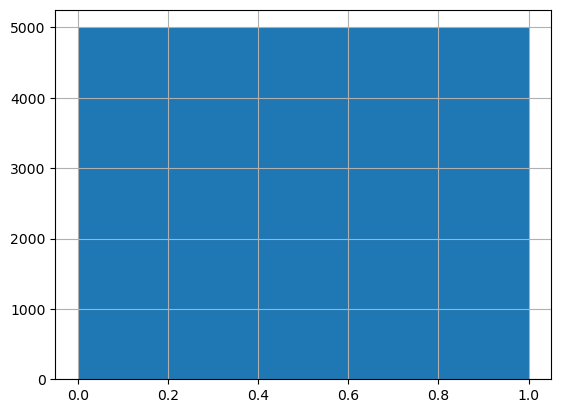

In [6]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
cell_data = classifier.classify_cells(cell_data, FIRST_FEATURE)

# Create config var for cell classes
CELL_CLASSES = list(cell_data["class"].unique())

print("Cell class counts:")
print(cell_data["class"].value_counts())

print("\nCell class confidences:")
cell_data["confidence"].hist()
plt.show()

Montages of cell classes:


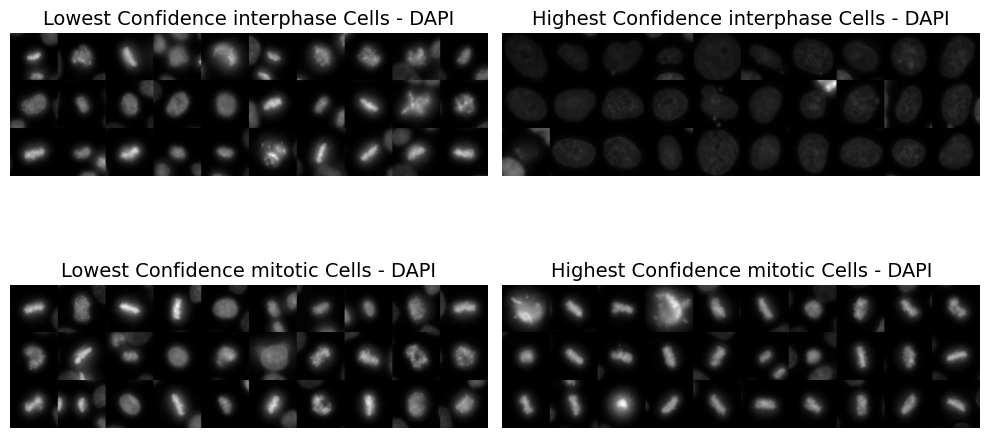

Split cell data summary:


,Stage,Count
0,Raw Data,50000
1,interphase cells,49538
2,interphase sgRNA_0,9544
3,interphase gene_symbol_0,4595
4,mitotic cells,462
5,mitotic sgRNA_0,125
6,mitotic gene_symbol_0,125


In [7]:
classified_cell_data = cell_data.copy()
classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_cell_data[classified_cell_data["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(
            title_templates[ascending].format(
                cell_class=cell_class, channel=MONTAGE_CHANNEL
            )
        )

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

print("Montages of cell classes:")
plt.tight_layout()
plt.show()

print("Split cell data summary:")
summary_df = summarize_cell_data(cell_data, CELL_CLASSES, COLLAPSE_COLS)
summary_df

## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation
- `PERTURBATION_MULTI_COL`: Name of column that has a boolean flag for if multiple perturbations are detected
- `FILTER_SINGLE_PERT`: Whether or not to only keep cells that have a single perturbation

Found 22753 cells with assigned perturbations
Unique populations: 4601


,column,percent_na
52,cytoplasm_DAPI_mean_frac_0,0.690898
53,cytoplasm_COXIV_mean_frac_0,0.690898
54,cytoplasm_CENPA_mean_frac_0,0.690898
55,cytoplasm_WGA_mean_frac_0,0.690898
56,cytoplasm_DAPI_mean_frac_1,0.652134
57,cytoplasm_COXIV_mean_frac_1,0.652134
58,cytoplasm_CENPA_mean_frac_1,0.652134
59,cytoplasm_WGA_mean_frac_1,0.652134
68,cytoplasm_DAPI_radial_cv_0,0.690898
69,cytoplasm_COXIV_radial_cv_0,0.690898


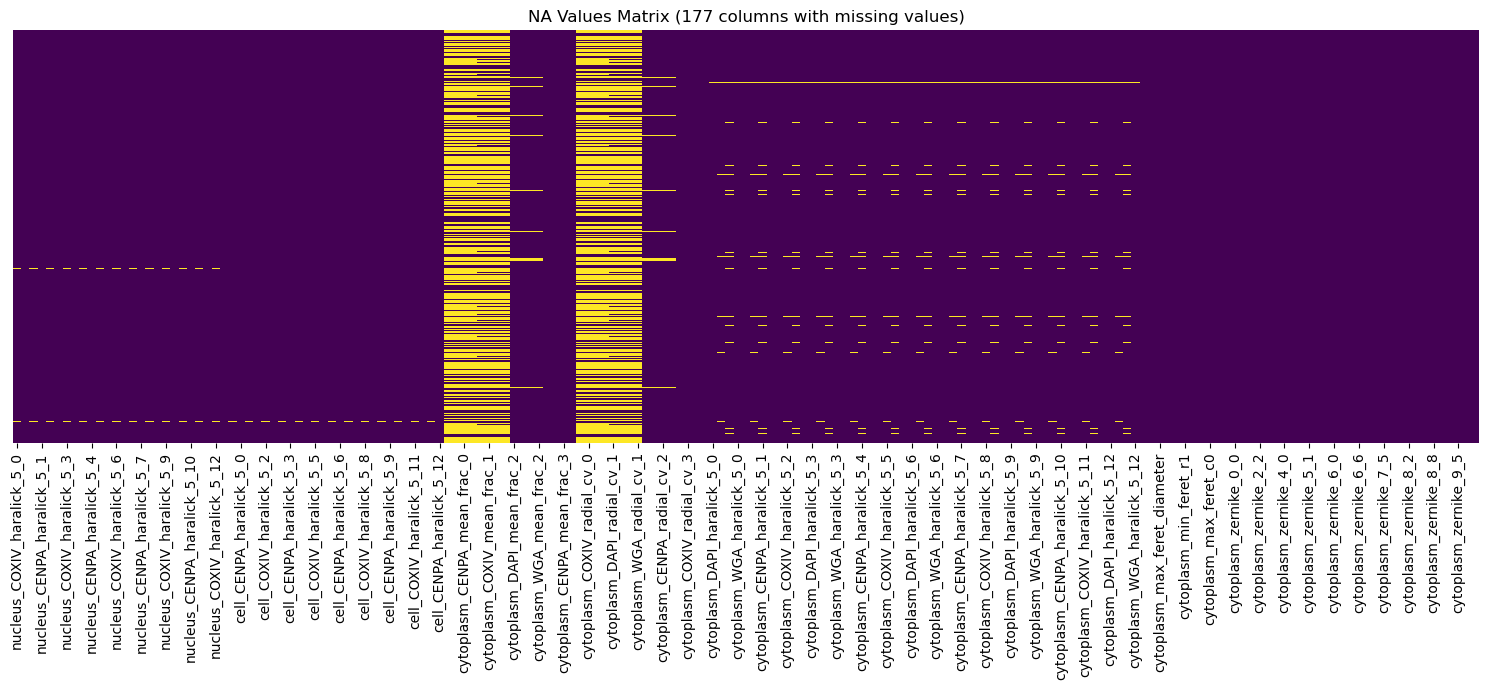

In [8]:
PERTURBATION_NAME_COL = "gene_symbol_0"
PERTURBATION_MULTI_COL = "mapped_single_gene"
FILTER_SINGLE_PERT = False

perturbation_filtered = perturbation_filter(
    cell_data, PERTURBATION_NAME_COL, PERTURBATION_MULTI_COL, FILTER_SINGLE_PERT
)
print(f"Unique populations: {perturbation_filtered[PERTURBATION_NAME_COL].nunique()}")

sumamry_df, fig = nas_summary(perturbation_filtered)
sumamry_df[sumamry_df["percent_na"] > 0.1]

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [9]:
DROP_COLS_THRESHOLD = 0.1
CONTAMINATION = 0.01

In [ ]:
# Filter by missing values
missing_values_filtered = missing_values_filter(
    perturbation_filtered, FIRST_FEATURE, drop_cols_threshold=DROP_COLS_THRESHOLD
)

intesity_filtered = intensity_filter(
    missing_values_filtered,
    FIRST_FEATURE,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

intesity_filtered

Dropping 16 columns with ≥10.0% missing values
Imputing 161 columns with remaining missing values


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22521,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22522,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22523,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`

In [11]:
BATCH_COLS = ["plate", "well"]

Number of components needed for 95.0% variance: 432
Shape of input data: (22525, 1651)
Shape of PCA transformed and reduced data: (22525, 432)
Top 10 pertubration counts:


gene_symbol_0
nontargeting    522
KLF5             22
ZNF286B          21
ARPC4-TTLL3      21
LMAN2            21
DCAF13           21
PHB              21
IREB2            20
TIAL1            20
TM2D2            20
Name: count, dtype: Int64

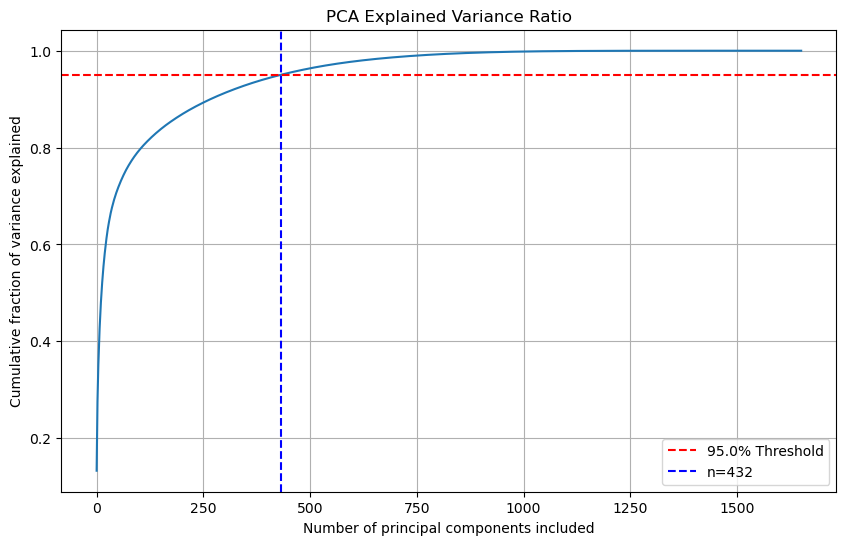

In [12]:
features, metadata = prepare_alignment_data(
    intesity_filtered, BATCH_COLS, FIRST_FEATURE
)

pca_df_threshold, n_components, pca, fig = pca_variance_plot(
    features, variance_threshold=0.95
)

print("Top 10 pertubration counts:")
metadata[PERTURBATION_NAME_COL].value_counts()[:10]

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `PC_COUNT`: Number of principal components to use when creating embeddings with PCA (see figure above). Usually the amount of principal components needed to explain 95% of variance (see above).
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `mean`.

In [13]:
PC_COUNT = 428
CONTROL_KEY = "nontargeting"
AGG_METHOD = "mean"

/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(
/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(


Aligned feature distribtutions:


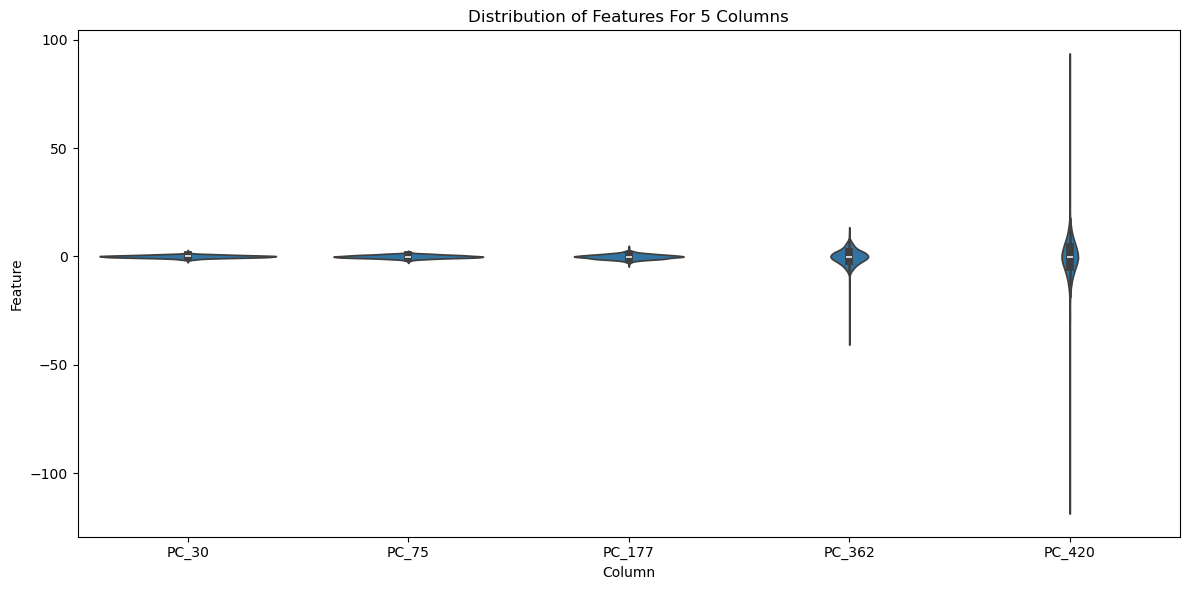

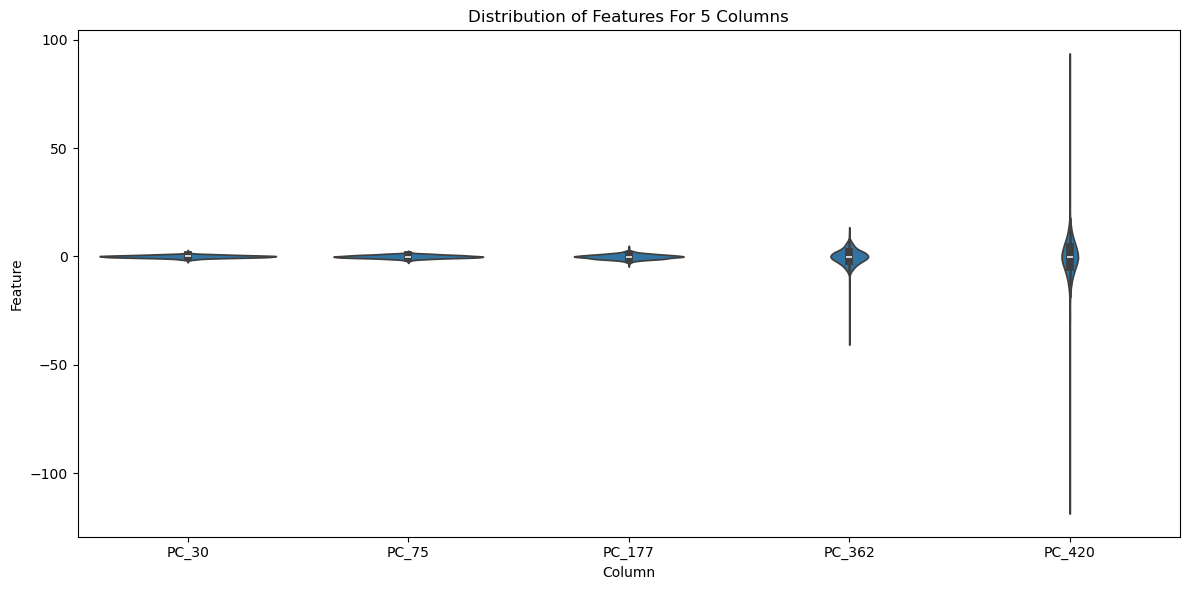

In [16]:
pca_embeddings = embed_by_pca(
    features.values, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values"
)
tvn_normalized = tvn_on_controls(
    pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

print("Aligned feature distribtutions:")
plot_feature_distributions(aligned_cell_data, "PC_0", num_features=5)

## Add aggregate parameters to config file

In [15]:
# Add aggregate section
config["aggregate"] = {
    "classifier_path": CLASSIFIER_PATH,
    "first_feature": FIRST_FEATURE,
    "montage_channel": MONTAGE_CHANNEL,
    "collapse_cols": COLLAPSE_COLS,
    "cell_classes": ["all"] + CELL_CLASSES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "perturbation_multi_col": PERTURBATION_MULTI_COL,
    "filter_single_pert": FILTER_SINGLE_PERT,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "pc_count": PC_COUNT,
    "control_key": CONTROL_KEY,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)